In [1]:
import numpy as np
import random
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
cities = pd.read_csv('french_locations.csv')
adjacency_matrix = np.genfromtxt('french_distances.csv', delimiter=',')

In [3]:
# Geojson file taken from: https://github.com/gregoiredavid/france-geojson/blob/master/regions-version-simplifiee.geojson
france = gpd.read_file('france.geojson')

In [4]:
edges_x = [(cities.loc[i]['Long'], cities.loc[j]['Long']) for i in range(30) for j in range(30) if i < j and adjacency_matrix[i, j]==1]
edges_y = [(cities.loc[i]['Lat'], cities.loc[j]['Lat']) for i in range(30) for j in range(30) if i < j and adjacency_matrix[i, j]==1]
n_edges = len(edges_x)

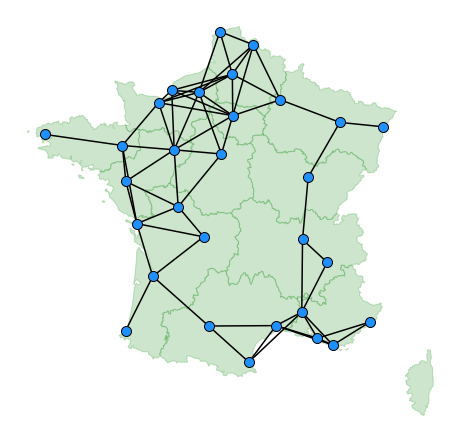

In [5]:
fig, ax = plt.subplots(1, figsize=(8, 8))
france.plot(color='green', alpha=0.2, ax=ax, edgecolor='green')
for e in range(n_edges):
    ax.plot(edges_x[e], edges_y[e], c='black')
ax.scatter(cities['Long'], cities['Lat'], s=100, c='dodgerblue', edgecolor='black', zorder=2)
ax.axis('off')
fig.savefig('adjacency.pdf')

In [6]:
class AdvertisingCampaign:
    """
    A Class to create an AdvertisingCampaign object.
    Holds information about the cities and their adjacency matrix.
    Contains methods to minimise the number of cities required to cover
    the set.
    """
    def __init__(self, cities, adj_matrix):
        """
        Initialises the object.
        """
        self.cities = cities
        self.number_of_cities = len(self.cities)
        self.adj_matrix = adj_matrix
        self.history = []
        self.best_score = len(self.cities)
        self.best_solution = np.array([1] *  self.number_of_cities)
        self.num_broadcasts_to_try = np.linalg.matrix_rank(self.adj_matrix)
    
    def evalutate_solution(self, solution):
        """
        Gives a score to a potential solution.
        If solution leaves any city out, returns self.number_of_cities,
        otherwise it returns the number of cities used for broadcasts.
        """
        coverage = np.matmul(solution, self.adj_matrix)
        if 0 in coverage:
            return self.number_of_cities
        return sum(solution)
    
    def new_solution(self):
        """
        Randomly generate a new potential solution
        with self.number_broadcasts_to_try broadcasts.
        """
        number_empty = self.number_of_cities - self.num_broadcasts_to_try
        sol = [1] * self.num_broadcasts_to_try + [0] * number_empty
        random.shuffle(sol)
        return np.array(sol)
    
    def optimise(self, num_itrs):
        """
        For num_itrs iterations, keep generating random potential
        solutions with self.number_broadcasts_to_try broadcasts. If solution
        is valid, reduce the number of broadcasts to try by 1. Keep track
        of best solution.
        """
        for iteration in range(num_itrs):
            solution = self.new_solution()
            score = self.evalutate_solution(solution)
            if score <= self.best_score:
                self.best_solution = solution
                self.best_score = score
                self.num_broadcasts_to_try = self.best_score - 1
            self.history.append(self.best_score)
    
    def print_solution(self):
        """
        Prints out the best solution.
        """
        for i, city in enumerate(self.cities):
            if self.best_solution[i] == 1:
                print(self.cities[i])

In [7]:
random.seed(1)
n_iters = 5000
A = AdvertisingCampaign(cities['City'], adjacency_matrix)
A.optimise(n_iters)

In [8]:
A.print_solution()

Avignon
Bordeaux
Limoges
Nancy
Nice
Rennes
Rouen


In [9]:
sol_numbers = [i for i in range(30) if A.best_solution[i]==1]
not_sol_numbers = [i for i in range(30) if A.best_solution[i]!=1]
solution_cities = cities.loc[sol_numbers]
not_solution_cities = cities.loc[not_sol_numbers]

In [10]:
solution_edges_x = [(cities.loc[i]['Long'], cities.loc[j]['Long']) for i in sol_numbers for j in range(30) if adjacency_matrix[i, j]==1]
solution_edges_y = [(cities.loc[i]['Lat'], cities.loc[j]['Lat']) for i in sol_numbers for j in range(30) if adjacency_matrix[i, j]==1]
n_solution_edges = len(solution_edges_x)

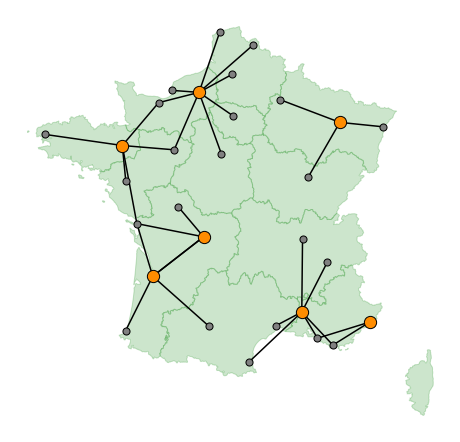

In [19]:
fig, ax = plt.subplots(1, figsize=(8, 8))
france.plot(color='green', alpha=0.2, ax=ax, edgecolor='green')
for e in range(n_solution_edges):
    ax.plot(solution_edges_x[e], solution_edges_y[e], c='black')
ax.plot([], [], c='black', label='Broadcast Reach')
ax.scatter(solution_cities['Long'], solution_cities['Lat'], s=150, c='darkorange', edgecolor='black', zorder=2, label='Broadcast Cities')
ax.scatter(not_solution_cities['Long'], not_solution_cities['Lat'], s=50, c='grey', edgecolor='black', zorder=2)
ax.axis('off')
fig.savefig('solution.pdf')

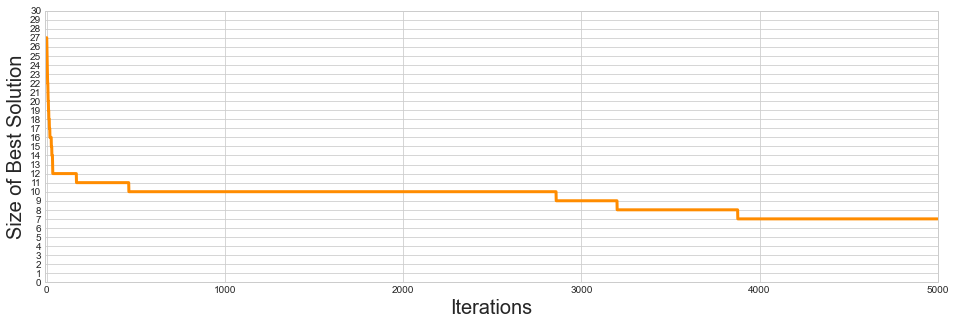

In [18]:
fig, ax = plt.subplots(1, figsize=(16, 5))
ax.plot(A.history, linewidth=3, c='darkorange')
ax.set_xlim(-10, n_iters)
ax.set_xlabel('Iterations', fontsize=20)
ax.set_ylabel('Size of Best Solution', fontsize=20)
ax.set_yticks(range(31))
fig.savefig('overtime.pdf')